# Challenge 1: Integrating Farmer and Weather Data Sets

## Overview

This notebook contains an analysis of historical weather patterns, ERA5 data, and the specific questions asked by smallholder farmers in Kenya, Uganda, and Tanzania. This notebook looks at rainfall anomalies and heat stress to determine trends in farmer questions topics, specifically looking at 'Pests & Disease' topics.

In [1]:
import os
import re
import duckdb
import sklearn
import nltk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Importing and setting path files to already translated parquet files and era5 country data.
current_directory = Path(os.getcwd())

root_directory = current_directory.joinpath('../..')

original_parquet_path = root_directory.joinpath('data/b0cd514b-b9cc-4972-a0c2-c91726e6d825.parquet')

# split data file paths
eng_parquet_path = root_directory.joinpath('data/eng.parquet')
# already sampled to obtain 0.5 percent of data of each language
swa_parquet_path = root_directory.joinpath('data/swa_translated_sample.parquet')
lug_parquet_path = root_directory.joinpath('data/lug_translated_sample.parquet')
nyn_parquet_path = root_directory.joinpath('data/nyn_translated_sample.parquet')

# split era5 data with tasmax, tasmin and prcp information for each country
kenya_era5_path = root_directory.joinpath('data/era5_kenya.xlsx')
tanzania_era5_path = root_directory.joinpath('data/era5_tanzania.xlsx')
uganda_era5_path = root_directory.joinpath('data/era5_uganda.xlsx')


path_list = [swa_parquet_path, lug_parquet_path, nyn_parquet_path]
era5_map = {
    'KE': kenya_era5_path, 
    'TZ': tanzania_era5_path, 
    'UG': uganda_era5_path}

## Cleaning, Inspecting and Finalizing Topics via NLTK and LDA

In [44]:
# Obtaining 0.5 percent of the English parquet data file and 
# concatenating all files with selected columns into one data frame.
conn = duckdb.connect()

data_frames = []
sample_query = f"""
    SELECT question_id, question_content AS eng_content, question_user_country_code, question_sent, question_topic,
    FROM read_parquet('{eng_parquet_path}')
    USING SAMPLE 0.5% (bernoulli)
"""

eng_sample_df = conn.execute(sample_query).fetchdf()
data_frames.append(eng_sample_df)

for paths in path_list:
    df_transl = pd.read_parquet(paths)

    conn.register('translated_sample', df_transl)
    
    df = conn.execute(f"""
        SELECT 
            translated_sample.question_id,
            translated_sample.question_content,
            translated_sample.translated_en AS eng_content,
            translated_sample.src_lang,
            original_sample.question_user_country_code,
            original_sample.question_sent,
            original_sample.question_topic,
        FROM translated_sample
        LEFT JOIN read_parquet('{original_parquet_path}') AS original_sample 
        ON translated_sample.question_id = original_sample.question_id     
    """).fetchdf()
    
    data_frames.append(df)

conn.close()

all_df = pd.concat(data_frames, ignore_index=True)
all_df = all_df.drop_duplicates(subset=['question_id'], keep='first')
all_df = all_df.drop_duplicates(subset=['eng_content', 'question_sent'], keep='first')
all_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,question_id,eng_content,question_user_country_code,question_sent,question_topic,question_content,src_lang
0,34239087,I want 2 know more about catle.,None,2019-11-14 10:48:53.280116+00,cattle,NaN,NaN
1,34522655,Q How can i mantain my sukumawiki,ke,2019-11-22 07:36:34.631799+00,kale,NaN,NaN
2,36757835,Q the best month to plant maize and beas is?,ke,2020-01-23 12:52:24.461119+00,maize,NaN,NaN
3,36912180,Q Effects Of Crop Deseases,ke,2020-01-28 05:30:54.9177+00,crop,NaN,NaN
4,37012398,CAN WE PLANT MAIZE AT THIS SEASON?,ke,2020-01-31 03:01:22.720849+00,plant,NaN,NaN
...,...,...,...,...,...,...,...
355151,58826127,He is a memorialist and a retired army officer,ug,2021-09-03 06:37:17.209872-07:00,millet,E omubazi gwokufuhirira omwata gwomuburo...,nyn
355155,58833183,I go for a free health strike with a very big ...,ug,2021-09-03 10:20:38.918093-07:00,None,Ninyenda empunu zokugura breed nungi ninye pet...,nyn
355158,58839197,Q Your Officer Clears the Secrets,ug,2021-09-03 12:31:11.376986-07:00,bean,Q omubazi gwo kufuhira ebihiba,nyn
355160,58843449,The oil producers will be providing better ser...,ug,2021-09-04 00:10:17.006177-07:00,grass,E wanokuhinga ebiyobwa deru ayiwahinga ebiyans...,nyn


In [45]:
# Cleaning and lemmatizing via NLTK

# adding known hallucination words from looking at translated languages question content.

hallucination_words = ['attorney', 'general', 'prime', 'minister', 'parliament', 'football', 
    'premier', 'league', 'musician', 'contract', 'sinnin', 'guyaya', 
    'qipssss', 'aiiiiii']

updated_stops = [
    'want', 'ask', 'asks', 'help', 'question', 'fine', 'good', 'best', 
    'know', 'person', 'tell', 'thank', 'thanks', 'hello', 'dear', 'sir',
    'please', 'like', 'need',  'man', 'mother', 'brother', 'sister', 'body', 
    'piece', 'single', 'game', 'clean', 'filled', 'helping', 'search', 'pain', 
    'called', 'dont', 'start', 'day', 'world', 'thing', 'use', 'farmer', 'plant', 'planting'
]
custom_stops = set(stopwords.words('english'))
custom_stops.update(hallucination_words)
custom_stops.update(updated_stops)

lemmatizer = WordNetLemmatizer()

def clean_text(text): 
    text = str(text).lower()
    # replacing any punctuation
    text = re.sub(r'(.)\1{2,}', '', text)
    # split text and check select words not in custom_stops
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()

    clean_tokens = []
    for t in tokens:
        if t in custom_stops:
            continue
            
        if len(t) < 3 or len(t) > 12:
            continue
            
        # lemmatize words
        lemma = lemmatizer.lemmatize(t)
        
        if lemma not in custom_stops:
            clean_tokens.append(lemma)

    return " ".join(clean_tokens)

all_df['clean_eng_content'] = all_df['eng_content'].apply(clean_text)
all_df.head(5)

,question_id,eng_content,question_user_country_code,question_sent,question_topic,question_content,src_lang,clean_eng_content
0,34239087,I want 2 know more about catle.,None,2019-11-14 10:48:53.280116+00,cattle,NaN,NaN,catle
1,34522655,Q How can i mantain my sukumawiki,ke,2019-11-22 07:36:34.631799+00,kale,NaN,NaN,mantain sukumawiki
2,36757835,Q the best month to plant maize and beas is?,ke,2020-01-23 12:52:24.461119+00,maize,NaN,NaN,month maize beas
3,36912180,Q Effects Of Crop Deseases,ke,2020-01-28 05:30:54.9177+00,crop,NaN,NaN,effect crop deseases
4,37012398,CAN WE PLANT MAIZE AT THIS SEASON?,ke,2020-01-31 03:01:22.720849+00,plant,NaN,NaN,maize season


In [46]:
# Using LDA to investigate and inspect topic themes
clean_text = all_df['clean_eng_content'].fillna("").astype(str).tolist()

vectorizer = CountVectorizer(max_df=0.9, min_df=20, stop_words=list(custom_stops))
dtm = vectorizer.fit_transform(clean_text)

lda_model = LatentDirichletAllocation(n_components=4, random_state=42)
lda_output = lda_model.fit_transform(dtm)

def show_lda_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        term_list = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict[f"Topic {topic_idx}"] = term_list
        print(f"Topic {topic_idx}:")
        print(" ".join(term_list))
    return topic_dict

feature_names = vectorizer.get_feature_names_out()
topics = show_lda_topics(lda_model, feature_names, 10)

Topic 0:
many one take long month time get pig would water
Topic 1:
tomato banana medicine disease control corn seed coffee used tree
Topic 2:
maize crop type much bean seed price fertilizer farm potato
Topic 3:
cow chicken chick hen give egg goat animal feed milk


In [47]:
# Finalizing Topics by inspecting each row.
def define_keyword_category(row):
    combined_text = str(row['question_topic']).lower() + " " + str(row['clean_eng_content']).lower()

    bad_labels = ['other', 'none', 'nan', 'general']

    if any(x in combined_text for x in ['pest', 'worm', 'insect', 'beetle', 'locust', 'dudu', 'armyworm', 'tick', 'mite', 'disease', 'sick', 'wilt', 'rot', 'blight', 'fungus']): 
        return 'Pests & Disease'

    if any(x in combined_text for x in ['rain', 'downpour', 'drought', 'water', 'flood', 'weather', 'sun', 'dry', 'climate', 'season']): 
        return 'Weather'

    if any(x in combined_text for x in ['price', 'market', 'sell', 'buy', 'cost', 'shilling', 'money', 'profit', 'loan']): 
        return 'Market'

    if any(x in combined_text for x in ['cow', 'goat', 'chicken', 'milk', 'egg', 'hen', 'bull', 'calf', 'animal', 'poultry', 'cattle', 'livestock']): 
        return 'Livestock'

    if any(x in combined_text for x in ['maize', 'corn', 'bean', 'seed', 'plant', 'harvest', 'garden', 'farm', 'fertilizer', 'tomato', 'potato', 'cassava', 'coffee', 'vegetable', 'onion']): 
        return 'Crops'

    return 'Other'

all_df['final_category'] = all_df.apply(define_keyword_category, axis=1)
print(all_df['final_category'].value_counts())

final_category
Crops              29200
Other              26292
Livestock          24831
Pests & Disease     6432
Weather             5768
Market              5274
Name: count, dtype: int64


## Integrating Farmer and Weather (ERA5) Data

In [48]:
# Cleaning and removing missing values.
all_df['question_sent'] = pd.to_datetime(all_df['question_sent'], utc=True, format='ISO8601', errors='coerce')
all_df['month_key'] = all_df['question_sent'].dt.tz_localize(None).dt.to_period('M')

if 'src_lang' in all_df.columns:
    mask_ug = (all_df['question_user_country_code'].isna()) & (all_df['src_lang'].isin(['lug', 'nyn']))
    all_df.loc[mask_ug, 'question_user_country_code'] = 'UG'

before_len = len(all_df)
cleaned_df = all_df.dropna(subset=['question_user_country_code', 'question_sent']).copy()
after_len = len(cleaned_df)

print(f"Dropped {before_len - after_len} rows due to missing Date/Location info.")
print(f"Remaining Rows: {len(all_df)}")

cleaned_df['question_user_country_code'] = cleaned_df['question_user_country_code'].astype(str).str.lower().str.strip()
country_map = {
    'ke': 'KE', 'ken': 'KE', 'kenya': 'KE', 
    'ug': 'UG', 'uga': 'UG', 'uganda': 'UG', 
    'tz': 'TZ', 'tza': 'TZ', 'tanzania': 'TZ'
}

cleaned_df['question_user_country_code'] = cleaned_df['question_user_country_code'].map(country_map)
cleaned_df = cleaned_df.dropna(subset=['question_user_country_code'])

print("Rows after Country Cleanup:", len(cleaned_df))

Dropped 1374 rows due to missing Date/Location info.
Remaining Rows: 97797
Rows after Country Cleanup: 96400


In [49]:
# Grouping all monthly question topics. 
monthly_questions_df = cleaned_df.groupby(['question_user_country_code', 
                                           'month_key', 'final_category']).size().reset_index(name='question_count')
monthly_questions_df

,question_user_country_code,month_key,final_category,question_count
0,KE,2017-11,Crops,33
1,KE,2017-11,Livestock,38
2,KE,2017-11,Market,10
3,KE,2017-11,Other,34
4,KE,2017-11,Pests & Disease,6
...,...,...,...,...
785,UG,2021-09,Livestock,42
786,UG,2021-09,Market,12
787,UG,2021-09,Other,114
788,UG,2021-09,Pests & Disease,22


In [50]:
# Reading ERA5 files and combining into one dataframe.
def process_excel_file(path, country_code):
    xlsx_file = pd.ExcelFile(path)

    def load_sheet(sheet_number, value_name): 
        df = pd.read_excel(xlsx_file, sheet_name=sheet_number)
        df_melt = pd.melt(
            df, 
            id_vars = ['code', 'name'],
            var_name = 'date',
            value_name = value_name
        )

        return df_melt

    df_prcp = load_sheet(0, 'prcp')
    df_tasmax = load_sheet(1, 'tasmax')
    df_tasmin = load_sheet(2, 'tasmin')

    df_combined = pd.merge(df_prcp, df_tasmax, on=['code', 'name', 'date'])
    df_combined = pd.merge(df_combined, df_tasmin, on=['code', 'name', 'date'])

    df_combined['code'] = country_code
    df_combined['date'] = pd.to_datetime(df_combined['date'])

    return df_combined

weather_dfs = []

for path_country, path in era5_map.items(): 
    df_country = process_excel_file(path, path_country)
    weather_dfs.append(df_country)

weather_combined_df = pd.concat(weather_dfs, ignore_index=True)

df_weather_final = weather_combined_df.groupby(['code', 'date']).agg({
    'prcp': 'mean',
    'tasmax': 'mean',
    'tasmin': 'mean'
}).reset_index()

df_weather_final['month_key'] = df_weather_final['date'].dt.to_period('M')

In [51]:
# Adding monthly lags to weather data before merging.
df_weather_final = df_weather_final.sort_values(['code', 'date'])

# Shows a month agos prcp shift
df_weather_final['prcp_lag1'] = df_weather_final.groupby('code')['prcp'].shift(1) 
# Shows two month agos prcp shift
df_weather_final['prcp_lag2'] = df_weather_final.groupby('code')['prcp'].shift(2)
# Shows two month agos tasmax shift
df_weather_final['tasmax_lag1'] = df_weather_final.groupby('code')['tasmax'].shift(1)

df_weather_final.head(5)

,code,date,prcp,tasmax,tasmin,month_key,prcp_lag1,prcp_lag2,tasmax_lag1
0,KE,1950-01-01,46.34,30.40,20.11,1950-01,NaN,NaN,NaN
1,KE,1950-02-01,21.06,31.79,20.43,1950-02,46.34,NaN,30.40
2,KE,1950-03-01,138.63,29.45,20.37,1950-03,21.06,46.34,31.79
3,KE,1950-04-01,219.78,27.17,19.92,1950-04,138.63,21.06,29.45
4,KE,1950-05-01,120.62,26.49,19.18,1950-05,219.78,138.63,27.17


In [52]:
# Calculating anomalies
df_weather_final['month_num'] = df_weather_final['date'].dt.month

# calculating 'normal' values
climatology = df_weather_final.groupby(['code', 'month_num'])[['prcp', 'tasmax']].mean().reset_index()
climatology = climatology.rename(columns={'prcp': 'prcp_normal', 'tasmax': 'tasmax_normal'})

df_weather_final = pd.merge(df_weather_final, climatology, on=['code', 'month_num'], how='left')
# calculating differences from normal
df_weather_final['prcp_anomaly'] = df_weather_final['prcp'] - df_weather_final['prcp_normal']
df_weather_final['tasmax_anomaly'] = df_weather_final['tasmax'] - df_weather_final['tasmax_normal']

# filtering for analysis periods
start_date = '2017-01-01'
df_weather_modeling = df_weather_final[df_weather_final['date'] >= start_date].copy()
df_weather_modeling['month_key'] = df_weather_modeling['date'].dt.to_period('M')
df_weather_modeling['year'] = df_weather_modeling['date'].dt.to_period('Y')
df_weather_modeling.head(5)

,code,date,prcp,tasmax,tasmin,month_key,prcp_lag1,prcp_lag2,tasmax_lag1,month_num,prcp_normal,tasmax_normal,prcp_anomaly,tasmax_anomaly,year
804,KE,2017-01-01,9.42,32.65,20.29,2017-01,34.02,85.57,31.06,1,39.691781,31.129726,-30.271781,1.520274,2017
805,KE,2017-02-01,17.90,32.66,21.75,2017-02,9.42,34.02,32.65,2,33.510685,32.142603,-15.610685,0.517397,2017
806,KE,2017-03-01,23.86,33.94,22.76,2017-03,17.90,9.42,32.66,3,72.496712,31.957671,-48.636712,1.982329,2017
807,KE,2017-04-01,68.79,32.40,22.73,2017-04,23.86,17.90,33.94,4,128.040548,30.212055,-59.250548,2.187945,2017
808,KE,2017-05-01,96.74,30.49,21.78,2017-05,68.79,23.86,32.40,5,88.757945,29.491233,7.982055,0.998767,2017


In [53]:
# Merging with farmer's questions to get final dataframe.
df_final_analysis = pd.merge(
    monthly_questions_df,  
    df_weather_modeling,    
    left_on=['question_user_country_code', 'month_key'],
    right_on=['code', 'month_key'],
    how='inner'
)
df_final_analysis

,question_user_country_code,month_key,final_category,question_count,code,date,prcp,tasmax,tasmin,prcp_lag1,prcp_lag2,tasmax_lag1,month_num,prcp_normal,tasmax_normal,prcp_anomaly,tasmax_anomaly,year
0,KE,2017-11,Crops,33,KE,2017-11-01,105.83,29.70,21.13,90.05,50.03,31.45,11,103.701233,29.388767,2.128767,0.311233,2017
1,KE,2017-11,Livestock,38,KE,2017-11-01,105.83,29.70,21.13,90.05,50.03,31.45,11,103.701233,29.388767,2.128767,0.311233,2017
2,KE,2017-11,Market,10,KE,2017-11-01,105.83,29.70,21.13,90.05,50.03,31.45,11,103.701233,29.388767,2.128767,0.311233,2017
3,KE,2017-11,Other,34,KE,2017-11-01,105.83,29.70,21.13,90.05,50.03,31.45,11,103.701233,29.388767,2.128767,0.311233,2017
4,KE,2017-11,Pests & Disease,6,KE,2017-11-01,105.83,29.70,21.13,90.05,50.03,31.45,11,103.701233,29.388767,2.128767,0.311233,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,UG,2021-09,Livestock,42,UG,2021-09-01,193.56,27.08,18.98,112.97,80.20,27.62,9,154.462192,26.890274,39.097808,0.189726,2021
786,UG,2021-09,Market,12,UG,2021-09-01,193.56,27.08,18.98,112.97,80.20,27.62,9,154.462192,26.890274,39.097808,0.189726,2021
787,UG,2021-09,Other,114,UG,2021-09-01,193.56,27.08,18.98,112.97,80.20,27.62,9,154.462192,26.890274,39.097808,0.189726,2021
788,UG,2021-09,Pests & Disease,22,UG,2021-09-01,193.56,27.08,18.98,112.97,80.20,27.62,9,154.462192,26.890274,39.097808,0.189726,2021


## Farmer Questions and ERA5 Visualizations

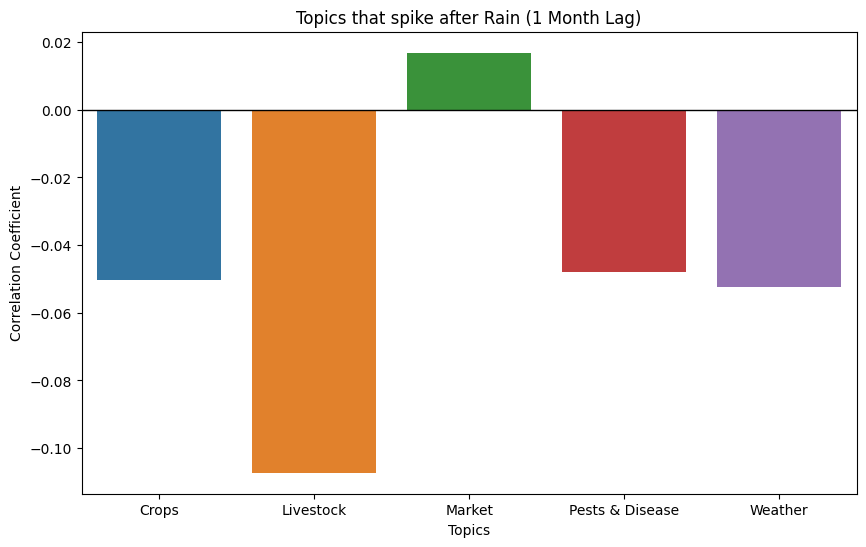

In [70]:
# Visualizing correlation with lagged precipitation 
df_corr_init =  df_final_analysis.pivot_table(
    index=['question_user_country_code', 'month_key', 'prcp', 'prcp_lag1', 'tasmax'],
    columns='final_category',
    values='question_count',
    fill_value=0
).reset_index()

prcp_lag_correlations = df_corr_init.corr(numeric_only=True)['prcp_lag1']

plt.figure(figsize=(10, 6))

topic_columns = ['Crops', 'Livestock', 'Market', 'Pests & Disease', 'Weather']
sns.barplot(x=prcp_lag_correlations[topic_columns].index, y=prcp_lag_correlations[topic_columns].values, hue=prcp_lag_correlations[topic_columns].index)
plt.axhline(0, color='black', linewidth=1)
plt.title("Topics that spike after Rain (1 Month Lag)")
plt.xlabel("Topics")
plt.ylabel("Correlation Coefficient")
plt.show()

In [71]:
# Inspecting Kenya to check if multiple countries caused low correlation scores in previous cell.
ke_data = df_final_analysis[df_final_analysis['question_user_country_code'] == 'KE'].copy()
ke_pivot =  ke_data.pivot_table(
    index='month_key',
    columns='final_category',
    values='question_count',
    fill_value=0
)

ke_weather = ke_data[['month_key', 'prcp_lag1']].drop_duplicates().set_index('month_key')
ke_check = pd.concat([ke_pivot, ke_weather], axis=1)

print("Correlation in Kenya Only:")
print(ke_check.corr(numeric_only=True)['prcp_lag1'])

Correlation in Kenya Only:
Crops             -0.087633
Livestock         -0.027152
Market            -0.024872
Other             -0.008305
Pests & Disease   -0.023033
Weather           -0.096802
prcp_lag1          1.000000
Name: prcp_lag1, dtype: float64


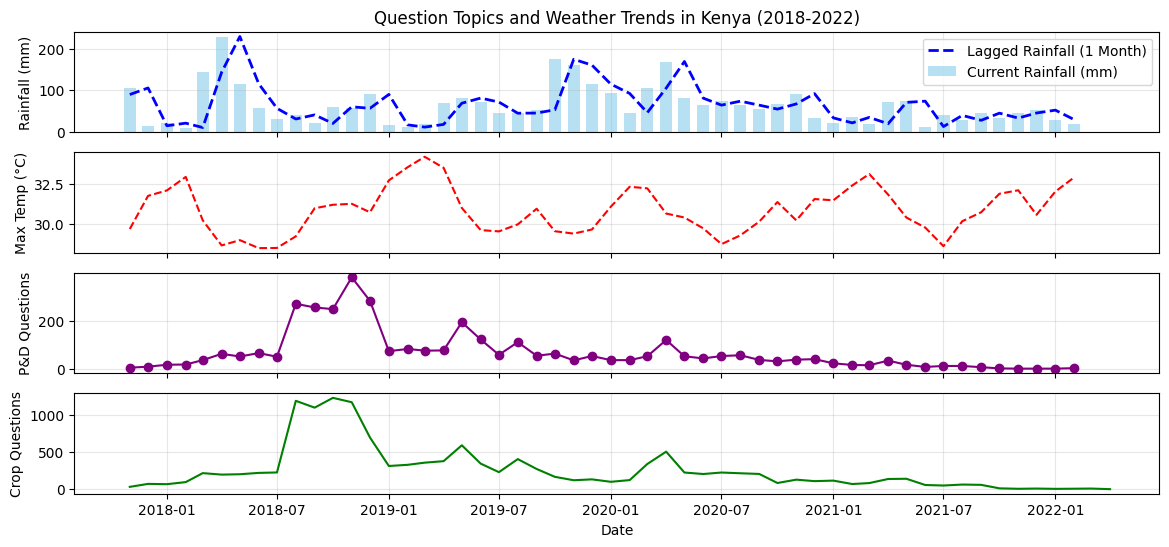

In [142]:
# Visualizing Questions and Weather Trends in Kenya

ke_plot_df = df_final_analysis[
    (df_final_analysis['code'] == 'KE') & 
    (df_final_analysis['final_category'] == 'Pests & Disease')
].copy()

crop_plot_df = df_final_analysis[
    (df_final_analysis['code'] == 'KE') & 
    (df_final_analysis['final_category'] == 'Crops')
].copy()


fig, axs = plt.subplots(4, 1, sharex = True, figsize=(14, 6))

axs[0].set_title('Question Topics and Weather Trends in Kenya (2018-2022)')

axs[0].bar(ke_plot_df['date'], ke_plot_df['prcp'], color='skyblue', label='Current Rainfall (mm)', width=20, alpha=0.6)
axs[0].plot(ke_plot_df['date'], ke_plot_df['prcp_lag1'], color='blue', linestyle='--', linewidth=2, label='Lagged Rainfall (1 Month)')
axs[0].set_ylabel('Rainfall (mm)')
axs[0].legend(loc='upper right')
axs[0].grid(True, alpha=0.3)

axs[1].plot(ke_plot_df['date'], ke_plot_df['tasmax'], color='red', linestyle='--', label='Max Temp')
axs[1].set_ylabel('Max Temp (°C)')
axs[1].grid(True, alpha=0.3)

axs[2].plot(ke_plot_df['date'], ke_plot_df['question_count'], color='purple', marker='o', label='Pests & Disease Questions')
axs[2].set_ylabel('P&D Questions')
axs[2].grid(True, alpha=0.3)

axs[3].plot(crop_plot_df['date'], crop_plot_df['question_count'], color='green', label='Crop Questions')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Crop Questions')
axs[3].grid(True, alpha=0.3)

plt.show()

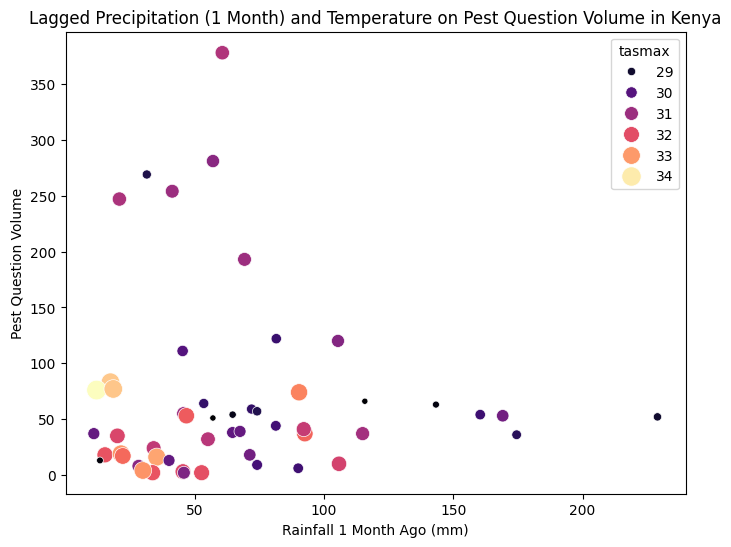

In [111]:
# Visualizing scatter plot of Lagged Rainfall, Temperature on Pest & Disease Questions
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ke_plot_df, 
                x='prcp_lag1', 
                y='question_count', 
                size='tasmax', sizes=(20, 200), hue='tasmax', palette='magma')
plt.title("Lagged Precipitation (1 Month) and Temperature on Pest Question Volume in Kenya")
plt.xlabel("Rainfall 1 Month Ago (mm)")
plt.ylabel("Pest Question Volume")
plt.show()

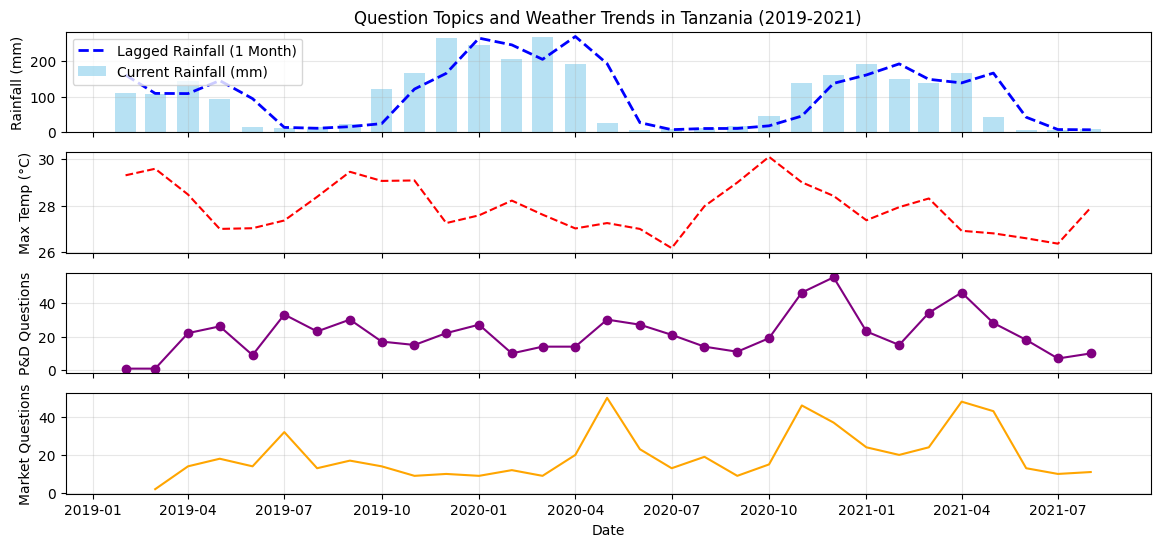

In [137]:
# Visualizing Weather and Question Trends in Tanzania
tz_plot_df = df_final_analysis[
    (df_final_analysis['code'] == 'TZ') & 
    (df_final_analysis['final_category'] == 'Pests & Disease')
].copy()

market_plot_df = df_final_analysis[
    (df_final_analysis['code'] == 'TZ') & 
    (df_final_analysis['final_category'] == 'Market') &
    (df_final_analysis['date'] >= '2019-03')
].copy()


fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 6))

axs[0].set_title('Question Topics and Weather Trends in Tanzania (2019-2021)')

axs[0].bar(tz_plot_df['date'], tz_plot_df['prcp'], color='skyblue', label='Current Rainfall (mm)', width=20, alpha=0.6)
axs[0].plot(tz_plot_df['date'], tz_plot_df['prcp_lag1'], color='blue', linestyle='--', linewidth=2, label='Lagged Rainfall (1 Month)')
axs[0].set_ylabel('Rainfall (mm)')
axs[0].legend(loc='upper left')
axs[0].grid(True, alpha=0.3)

axs[1].plot(tz_plot_df['date'], tz_plot_df['tasmax'], color='red', linestyle='--', label='Max Temp')
axs[1].set_ylabel('Max Temp (°C)')
axs[1].grid(True, alpha=0.3)

axs[2].plot(tz_plot_df['date'], tz_plot_df['question_count'], color='purple', marker='o', label='Pests & Disease Questions')
axs[2].set_ylabel('P&D Questions')
axs[2].grid(True, alpha=0.3)

axs[3].plot(market_plot_df['date'], market_plot_df['question_count'], color='orange', label='Market Questions')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Market Questions')
axs[3].grid(True, alpha=0.3)

plt.show()

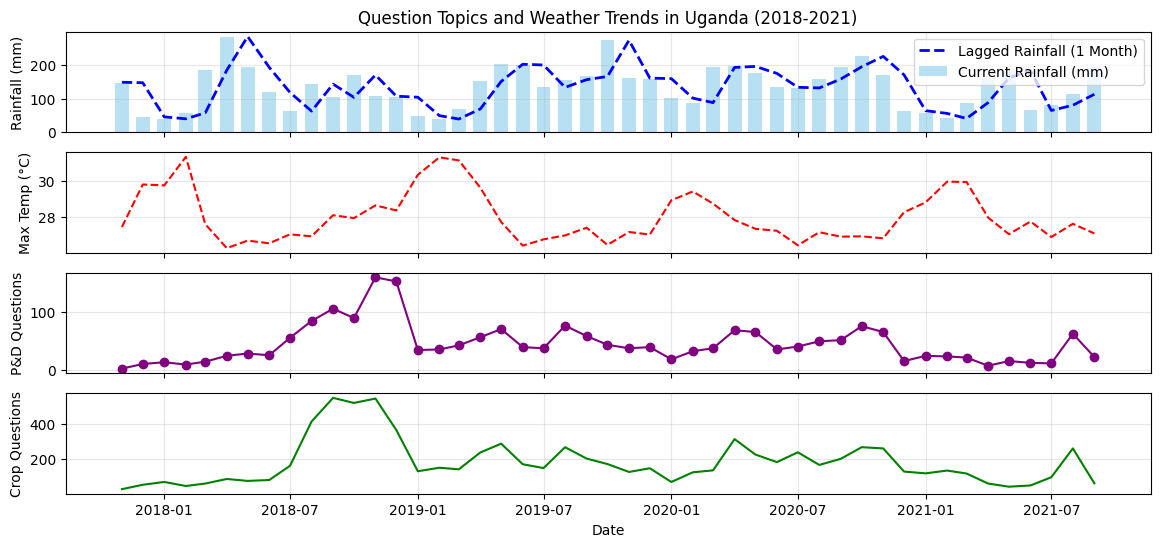

In [143]:
# Visualizing Questions and Weather Trends in Uganda
ug_plot_df = df_final_analysis[
    (df_final_analysis['question_user_country_code'] == 'UG') & 
    (df_final_analysis['final_category'] == 'Pests & Disease')
].copy()

crop_ug_plot_df = df_final_analysis[
    (df_final_analysis['code'] == 'UG') & 
    (df_final_analysis['final_category'] == 'Crops')
].copy()

fig, axs = plt.subplots(4, 1, sharex = True, figsize=(14, 6))

axs[0].set_title('Question Topics and Weather Trends in Uganda (2018-2021)')

axs[0].bar(ug_plot_df['date'], ug_plot_df['prcp'], color='skyblue', label='Current Rainfall (mm)', width=20, alpha=0.6)
axs[0].plot(ug_plot_df['date'], ug_plot_df['prcp_lag1'], color='blue', linestyle='--', linewidth=2, label='Lagged Rainfall (1 Month)')
axs[0].set_ylabel('Rainfall (mm)')
axs[0].legend(loc='upper right')
axs[0].grid(True, alpha=0.3)

axs[1].plot(ug_plot_df['date'], ug_plot_df['tasmax'], color='red', linestyle='--', label='Max Temp')
axs[1].set_ylabel('Max Temp (°C)')
axs[1].grid(True, alpha=0.3)

axs[2].plot(ug_plot_df['date'], ug_plot_df['question_count'], color='purple', marker='o', label='Pests & Disease Questions')
axs[2].set_ylabel('P&D Questions')
axs[2].grid(True, alpha=0.3)

axs[3].plot(crop_ug_plot_df['date'], crop_ug_plot_df['question_count'], color='green', label='Crop Questions')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Crop Questions')
axs[3].grid(True, alpha=0.3)
plt.savefig("ug_weather_topic_trends.png") 

plt.show()

## Preparing data for Estimation Model

In [60]:
# One-hot-encoding the Country Codes
def ohe_country_code(data):
    copy = data.copy()
    enc = OneHotEncoder()
    enc_fit = enc.fit(copy[["question_user_country_code"]])
    enc_data = enc.transform(copy[["question_user_country_code"]]).toarray()
    enc_df = pd.DataFrame(data=enc_data, columns=enc.get_feature_names_out(), index=copy.index) 
    return copy.join(enc_df)

ohe_data = ohe_country_code(df_final_analysis)

In [61]:
# Setting up Model
df_model = ohe_data.copy()

df_model['month_num'] = df_model['month_key'].dt.month.astype(int)
df_model['year'] = df_model['month_key'].dt.year.astype(int)

topics = ['Pests & Disease', 'Market', 'Livestock', 'Crops'] 
target = 'question_count'
features_chosen = ['month_num', 'year',
                   'prcp', 'prcp_lag1', 'prcp_lag2', 'prcp_anomaly',
                  'tasmax', 'tasmax_lag1', 'tasmax_anomaly',
                  'tasmin',
                   'question_user_country_code_KE', 'question_user_country_code_UG', 'question_user_country_code_TZ']
results = []
feature_importance_dict = {}

In [62]:
# Training and Test Loop
for topic in topics: 
    topic_df = df_model[df_model['final_category'] == topic].copy()

    topic_df = topic_df.dropna(subset=features_chosen + [target])
    
    if len(topic_df) < 50: 
        continue
        
    X = topic_df[features_chosen]
    y = topic_df[target]

    # Splitting training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
    
    # initiating RandomForest
    random_forest = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)

    # cross-validation using time series on the training set
    time_series_cv = TimeSeriesSplit(n_splits=4)
    
    cv_scores = cross_val_score(random_forest, X_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_error')
    avg_cv_rmse = -cv_scores.mean()

    random_forest.fit(X_train, y_train)
    predictions = random_forest.predict(X_test)

    final_rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # comparing test RMSE to CV RMSE
    std_dev = y_test.std()

    status =  "Strong" if final_rmse < std_dev else "Weak"

    print(f"{topic:<20} | {avg_cv_rmse:.2f}               | {final_rmse:.2f}               | {status}")

    feature_importance_dict[topic] = pd.Series(random_forest.feature_importances_, index=features_chosen)

Pests & Disease      | 63.71               | 18.90               | Strong
Market               | 37.71               | 22.31               | Strong
Livestock            | 294.29               | 101.16               | Weak
Crops                | 268.87               | 104.15               | Weak


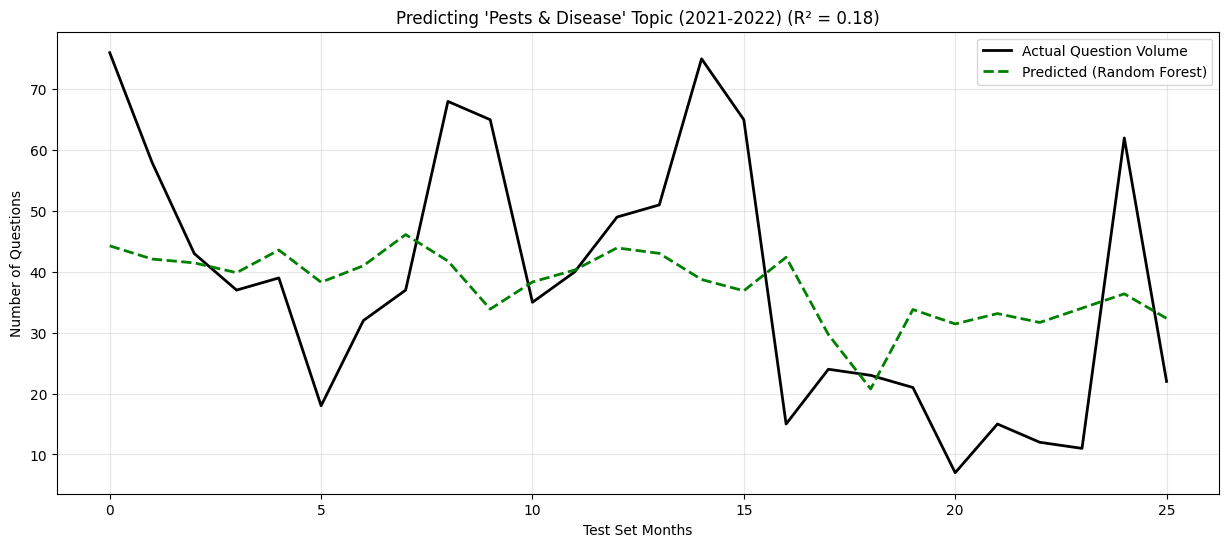

In [63]:
# Re-running to get Pest and Disease plot data
topic_df = df_model[df_model['final_category'] == 'Pests & Disease'].dropna()
X = topic_df[features_chosen]
y = topic_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

r2_value = random_forest.score(X_test, y_test)

plt.figure(figsize=(15, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual Question Volume', color='black', linewidth=2)
plt.plot(predictions, label='Predicted (Random Forest)', color='green', linestyle='--', linewidth=2)

plt.title(f"Predicting 'Pests & Disease' Topic (2021-2022) (R² = {r2_value:.2f})")
plt.xlabel("Test Set Months")
plt.ylabel("Number of Questions")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

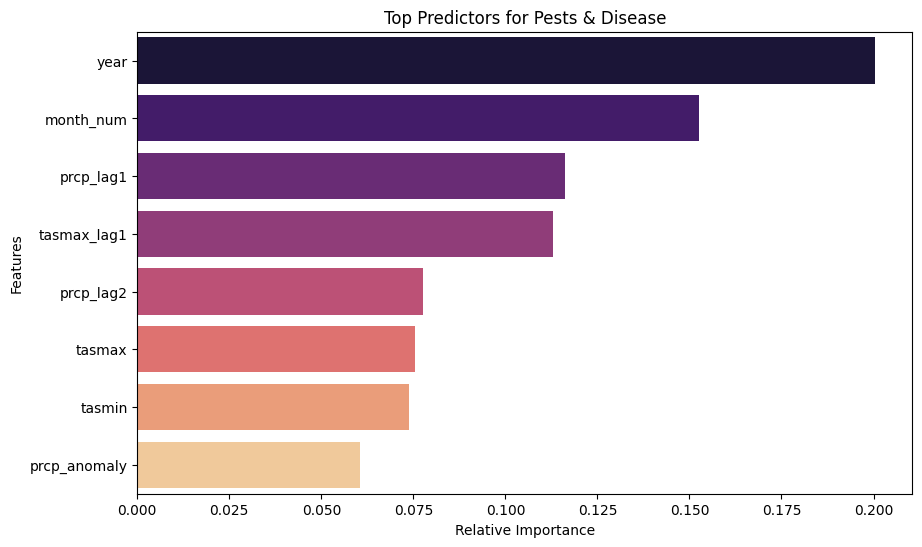

In [64]:
importance = pd.Series(random_forest.feature_importances_, index=features_chosen).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance.head(8).values, y=importance.head(8).index, hue=importance.head(8).index, palette='magma')
plt.title("Top Predictors for Pests & Disease")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.savefig("feature_importances.png") 
plt.show()